**<h1>📌 Visualizing Track Clustering with K-Means Analysis</h1>**

✅ *We integrated data from multiple sources, including track information, music attributes, lyrics, and genre details. After thorough data cleaning and preprocessing, we applied K-means clustering to categorize tracks based on various criteria. Utilizing the elbow method and its corresponding graph, we determined that five clusters were the optimal choice for grouping the tracks.*

**Importing Libraries** 📚

In [1]:
import pandas as pd
import seaborn as sns
import mysql.connector
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kmodes.kprototypes import KPrototypes

**Connecting to the Database** 📂

In [2]:
my_database = mysql.connector.connect(
host = "127.0.0.1",
port = "3306",
user = "root",
password = "Your Password",
auth_plugin = "mysql_native_password",
database = "spotify"
)

cursor = my_database.cursor()

**Reading data** 📡

In [3]:
query = """
SELECT * 
FROM track_info
join track_music on track_music.track_id = track_info.track_id
join track_lyric on track_lyric.track_id = track_info.track_id
join genre on genre.genre_id = track_info.genre_id
"""

cursor.execute(query)
track_data = cursor.fetchall()
track_df = pd.DataFrame(track_data, columns = [column[0] for column in cursor.description]) 
track_df = track_df.drop (["track_id", "artist_id", "genre_id", "subgenre_id", "album_id"], axis = 1)
track_df.head()

,popularity,title,explicit,track_asc,key,mode,loudness,tempo,duration_ms,time_signature,...,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,genres_name
0,418.00,it wont kill ya,0,a,6,0,-8.521,170.138,217613,4,...,0.200000,0,0,-1,1,0,0,0,0,pop
1,244.95,talking to myself,0,a,2,0,-6.325,124.013,231307,4,...,0.500000,0,10,-1,1,0,0,1,0,met
2,88.40,club paradise,1,a,6,0,-6.419,184.174,283816,4,...,0.413793,7,19,-1,1,0,0,0,0,hip
3,7959.50,versace on the floor,0,a,2,1,-6.209,174.152,261240,4,...,0.750000,0,4,1,0,0,1,0,1,pop
4,6575.75,sixteen,0,s,8,1,-5.445,109.919,201072,4,...,0.416667,0,6,1,0,0,1,0,1,pop


**Data Preparation and Processing** 📥

In [4]:
count_null = track_df.isna().sum()
count_null[count_null != 0]

anger_norm2           64
anticipation_norm2    64
disgust_norm2         64
fear_norm2            64
joy_norm2             64
sadness_norm2         64
surprise_norm2        64
trust_norm2           64
negative_norm2        57
positive_norm2        57
dtype: int64

In [5]:
track_df = track_df.dropna()

In [6]:
cat_cols = track_df.select_dtypes(include = ["object", "category"]).columns.tolist()
num_cols = list(set(track_df.columns) - set(cat_cols))
cat_cols[:3], num_cols[:3]

(['title', 'track_asc', 'genres_name'],
 ['negative_norm', 'afinn_norm', 'speechiness'])

In [7]:
le = preprocessing.LabelEncoder()
std_scaler = preprocessing.StandardScaler()

track_df.loc[:, cat_cols] = track_df.loc[:, cat_cols].apply(le.fit_transform)
track_df.loc[:, num_cols] = std_scaler.fit_transform(track_df.loc[:, num_cols])
track_df.head()

,popularity,title,explicit,track_asc,key,mode,loudness,tempo,duration_ms,time_signature,...,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,genres_name
0,-0.263265,2647,-0.826184,0,0.208522,-1.196777,-0.647528,1.744816,0.217136,0.11918,...,-1.517080,-0.593689,-0.919918,-0.868180,0.897944,-0.273156,-0.777822,-0.356700,-0.748761,12
1,-0.281730,5054,-0.826184,0,-0.893976,-1.196777,0.165364,0.118178,0.485898,0.11918,...,-0.086607,-0.593689,0.352402,-0.868180,0.897944,-0.273156,-0.777822,2.803477,-0.748761,10
2,-0.298433,979,1.210384,0,0.208522,-1.196777,0.130568,2.239808,1.516456,0.11918,...,-0.497663,0.555598,1.497490,-0.868180,0.897944,-0.273156,-0.777822,-0.356700,-0.748761,4
3,0.541411,5583,-0.826184,0,-0.893976,0.835577,0.208304,1.886373,1.073372,0.11918,...,1.105453,-0.593689,-0.410990,1.240761,-1.113656,-0.273156,1.285642,-0.356700,1.335539,12
4,0.393765,4645,-0.826184,2,0.759770,0.835577,0.491113,-0.378859,-0.107503,0.11918,...,-0.483959,-0.593689,-0.156526,1.240761,-1.113656,-0.273156,1.285642,-0.356700,1.335539,12


**PCA (Principal Component Analysis)** 📊

In [8]:
pca = PCA(n_components = 3)
track_df = pd.DataFrame(pca.fit_transform(track_df), \
columns = ["col" + str(i) for i in range(pca.n_components)])
track_df.head()

,col0,col1,col2
0,-371.879476,2.929685,0.516711
1,2035.120456,0.791409,-1.302990
2,-2039.880403,-6.501544,5.376928
3,2564.120735,2.932513,-4.187108
4,1626.120511,2.554357,-0.626970


**Clustering** 🌐

In [9]:
cost = []
for i in range(2, 21) : 
    m = KMeans(n_clusters = i, n_init = 10, random_state = 1402)
    m.fit(track_df)
    cost.append(m.inertia_)

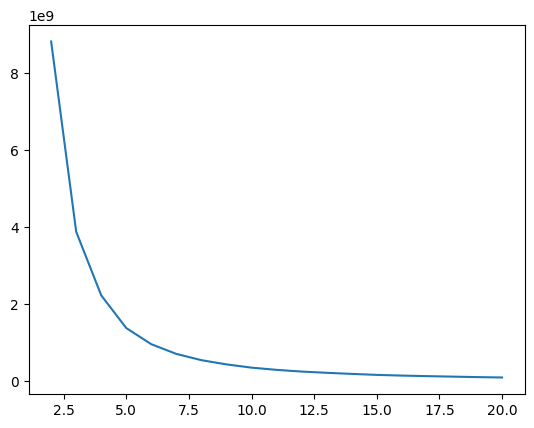

In [10]:
plt.plot(range(2, 21), cost)

In [11]:
n_clusters = 5
model = KMeans(n_clusters = n_clusters, n_init = 10, init = "k-means++", random_state = 1401)
model.fit(track_df)
track_df["cluster"] = model.predict(track_df)
track_df["cluster"]

0        4
1        0
2        2
3        0
4        3
        ..
11344    0
11345    3
11346    4
11347    2
11348    0
Name: cluster, Length: 11349, dtype: int32

In [12]:
track_df.cluster.value_counts()

cluster
4    2414
3    2353
1    2257
2    2218
0    2107
Name: count, dtype: int64

**Visualizing the clusters** 🧮

<AxesSubplot: xlabel='col0', ylabel='col2'>

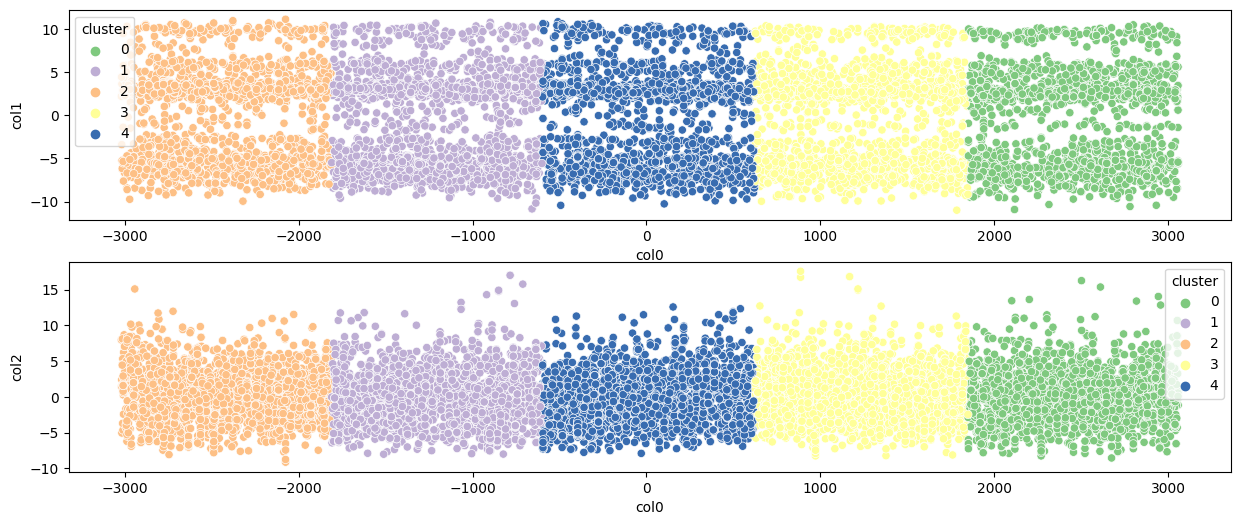

In [13]:
fig , ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 6))

sns.scatterplot(x = track_df.col0, y = track_df.col1, ax = ax[0], hue = track_df.cluster, palette = "Accent")
sns.scatterplot(x = track_df.col0, y = track_df.col2, ax = ax[1], hue = track_df.cluster, palette = "Accent")

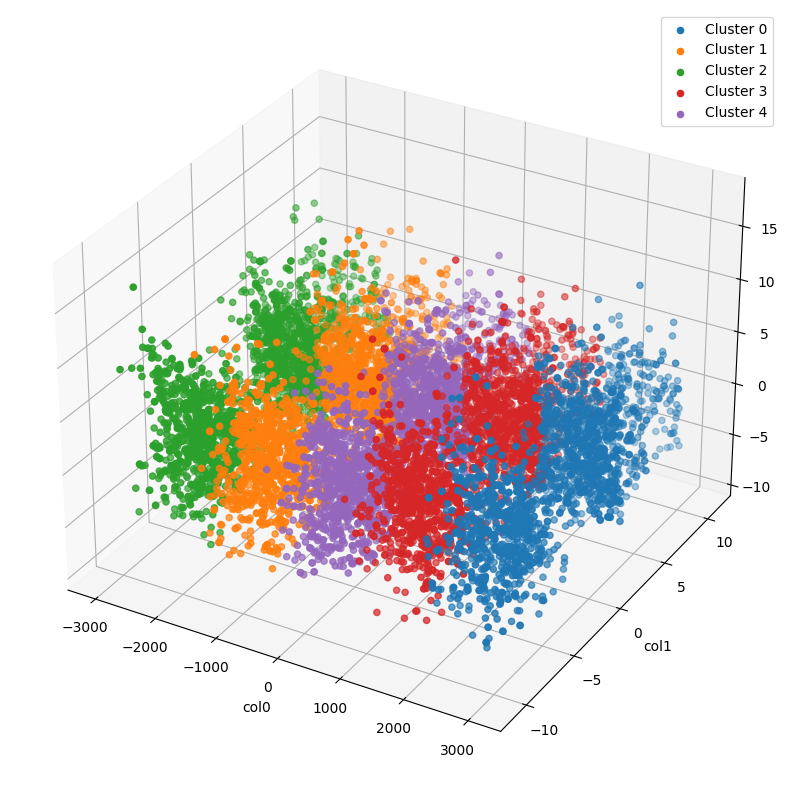

In [14]:
fig = plt.figure(figsize = (15, 10))
ax = plt.axes(projection = "3d")

for clu in range(n_clusters) : 
    ax.scatter3D(track_df.loc[track_df.cluster == clu, "col0"], track_df.loc[track_df.cluster == clu, "col1"], track_df.loc[track_df.cluster == clu, "col2"], label = "Cluster " + str(clu))


plt.xlabel("col0")
plt.ylabel("col1")
plt.legend()
plt.show()


In [15]:
custom_color_scale = ["rgb(139, 24, 116)", "rgb(183, 19, 117)", "rgb(252, 79, 0)", "rgb(247, 149, 64)", "rgb(255, 220, 220)", "rgb(113, 58, 190)"]

fig = px.scatter_3d(track_df, x = "col0", y = "col1", z = "col2", color = "cluster", color_continuous_scale = custom_color_scale, labels = {"col0": "X-Axis", "col1": "Y-Axis", "col2": "Z-Axis"},)

fig.update_layout(title = "3D Scatter Plot")
fig.show()
